In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.nn import LightGCN, GCNConv, GATConv
from torch_geometric.data import Data
import torch.nn.functional as F

In [2]:
print(torch.__version__)
print(torch_geometric.__version__)

2.6.0+cpu
2.6.1


In [3]:
# Load Excel
df = pd.read_excel('Online Retail.xlsx')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## The dataset consists of 541,909 entries and 8 columns:

- **`InvoiceNo`**: This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction. (This will by used later as a customer basket in the Leroy Merlin store).
- **`StockCode`**: An object data type column representing the product code for each item.
- **`Description`**: This column, also an object data type, contains descriptions of the products. It has some missing values, with 540,455 non-null entries out of 541,909.
- **`Quantity`**: This is an integer column indicating the quantity of products purchased in each transaction.
- **`InvoiceDate`**: A datetime column that records the date and time of each transaction.
- **`UnitPrice`**: A float column representing the unit price of each product.
- **`CustomerID`**: A float column that contains the customer ID for each transaction. This column has a significant number of missing values, with only 406,829 non-null entries out of 541,909.
- **`Country`**: An object column recording the country where each transaction took place.

In [6]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


In [7]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


## Data Cleaning & Transformation
### Handling Missing Values

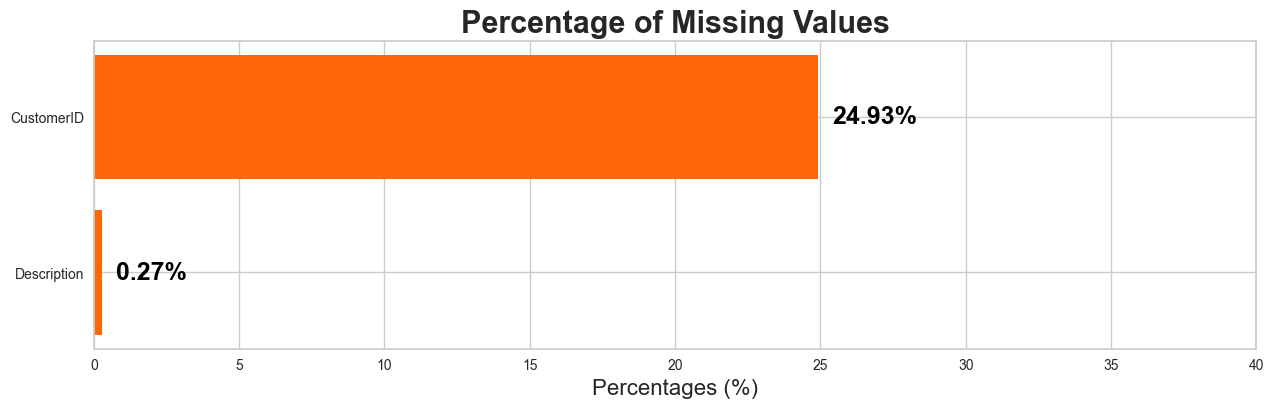

In [8]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color="#ff6200f7")

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

The **CustomerID** column contains nearly a quarter of missing data.

This column is essential for creating a recommendation system. 

Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

In [9]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [10]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [11]:
# Verifying the removal of missing values
df.isnull().sum().sum()

np.int64(0)

### Handling Duplicates

In [12]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


In [13]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [14]:
# Getting the number of rows in the dataframe
df.shape[0]

401604

## Treating Cancelled Transactions

Remove canceled transaction because they represent purchases that were reversed. Including them could distort the understanding of real buying behavior and mislead the recommendation model.

In [15]:
# Remove canceled transactions before modeling 
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [16]:
# Getting the number of rows in the dataframe
df.shape[0]

392732

## Correcting StockCode Anomalies

In [17]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3665


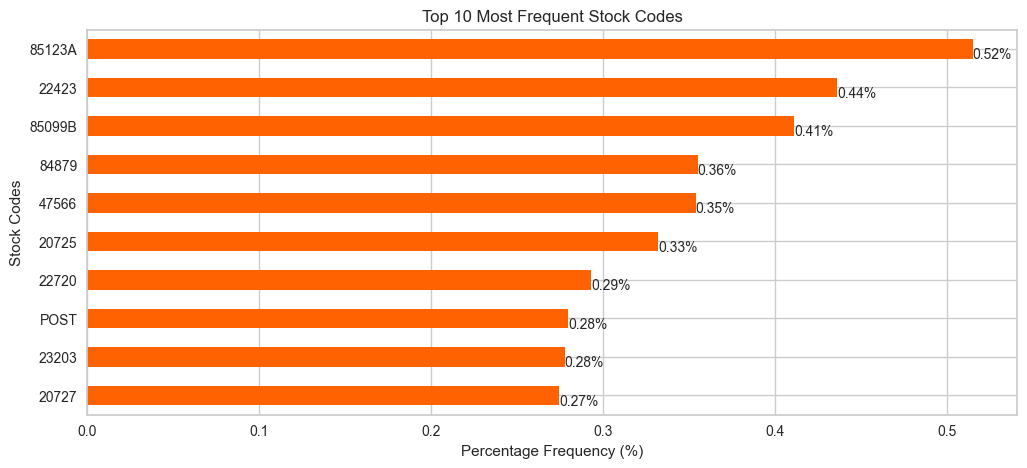

In [18]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

- We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products.

In [19]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3659
0       5
1       1
Name: count, dtype: int64


- Majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.
- There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.

In [20]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
C2
M
BANK CHARGES
PADS
DOT


In [21]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.39%


In [22]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [23]:
# Getting the number of rows in the dataframe
df.shape[0]

391183

### Cleaning Description Column

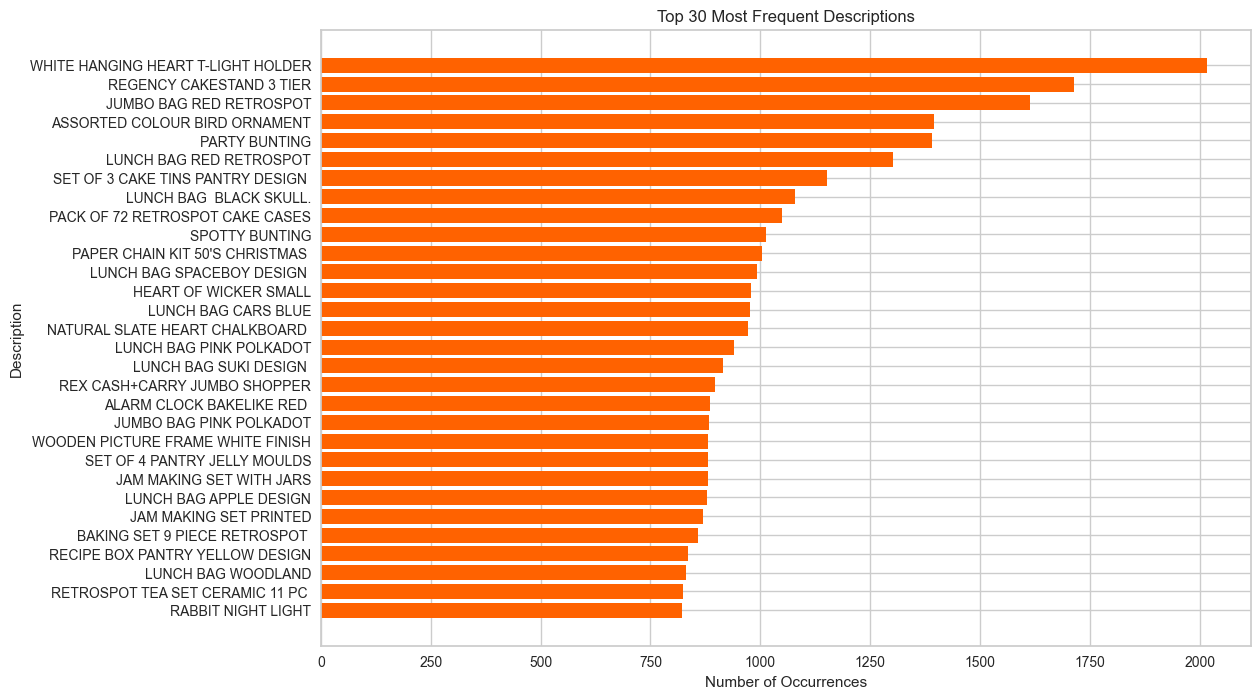

In [24]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items wich supports to our methedology of adapting this dataset to Leroy Merlin real data.

In [25]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
NUMBER TILE COTTAGE GARDEN No
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


- Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image".
- The next step is to Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the recommendation system we aim to build.
- For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.

In [26]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [27]:
# Getting the number of rows in the dataframe
df.shape[0]

391101

### Treating Zero Unit Prices

In [28]:
df['UnitPrice'].describe()

count    391101.000000
mean          2.871599
std           4.281346
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error.

In [29]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


- Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset.

In [30]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

## Leroy Merlin Data Adaptation

The goal is now to adapt the dataset to match the *Leroy Merlin* magazine by:

1. Treating each transaction as a basket.
2. Retaining only DIY, home decor, storage, tools, furniture, garden, bathroom, lighting, etc. products .

In [31]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a new column for basket ID (InvoiceNo)
df['BasketID'] = df['InvoiceNo'].astype(str)

# Standardize product descriptions
df['Description'] = df['Description'].str.strip().str.lower()

In [32]:
# Filter product names with DIY, home decor, storage, tools, furniture, garden, bathroom, lighting keywords
category_keywords = {
    'Home Decor': ['lantern', 'vase', 'cushion', 'lamp', 'mirror', 'frame', 'canvas', 'rug', 'curtain', 'blind'],
    'Storage & Organization': ['box', 'drawer', 'storage', 'basket', 'shelf', 'rack', 'wardrobe', 'cabinet'],
    'DIY Hardware': ['hook', 'holder', 'hinge', 'bracket', 'screw', 'nail', 'bolt', 'plug'],
    'Lighting': ['lamp', 'bulb', 'ceiling light', 'spotlight', 'chandelier', 'wall light'],
    'Garden': ['pot', 'planter', 'hose', 'spade', 'rake', 'watering can', 'greenhouse'],
    'Bathroom': ['mirror', 'soap dish', 'towel rail', 'toilet brush', 'bath mat'],
    'Kitchen': ['utensil holder', 'cutlery tray', 'storage jar', 'rack', 'spice rack'],
}
keywords = [item for sublist in category_keywords.values() for item in sublist]
df_diy = df[df['Description'].str.contains('|'.join(keywords))]

In [33]:
# treat each CustomerID + BasketID as a loyalty scan in a store
df_diy['ScanID'] = df_diy['CustomerID'].astype(str) + '_' + df_diy['BasketID']

C:\Users\pretil\AppData\Local\Temp\ipykernel_24680\3171335183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diy['ScanID'] = df_diy['CustomerID'].astype(str) + '_' + df_diy['BasketID']


In [34]:
df_diy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,BasketID,ScanID
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,536365,17850.0_536365
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,536365,17850.0_536365
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,536365,17850.0_536365
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,536365,17850.0_536365
14,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,536367,13047.0_536367
...,...,...,...,...,...,...,...,...,...,...
541892,581586,21217,red retrospot round cake tins,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,581586,13113.0_581586
541893,581586,20685,doormat red retrospot,10,2011-12-09 12:49:00,7.08,13113.0,United Kingdom,581586,13113.0_581586
541894,581587,22631,circus parade lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,581587,12680.0_581587
541902,581587,22629,spaceboy lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,581587,12680.0_581587


## 📊 Data Split

Before applying feature engineering and building the recommendation model, it is crucial to split the dataset into a **training set** and a **test set**. This ensures a fair and realistic evaluation of the recommendation system.

- The **training set** will be used to:
  - Cluster customers,
  - Identify top-selling products per cluster,
  - Generate personalized recommendations.

- The **test set** will represent **future customer purchases** and will be used to evaluate the performance of the recommendation system using metrics such as:
  - **Lift**
  - **P-value**
  - **Confidence Intervals**

To simulate future behavior, we define a cutoff date:

> **All customer transactions after `01/09/2011` are treated as future purchases and included in the test set.**

In [35]:
# Define the cutoff date
cutoff_date = pd.to_datetime("2011-09-01")

# Split the data
df_future = df_diy[df_diy['InvoiceDate'] > cutoff_date].copy()   # Future purchases
df_diy = df_diy[df_diy['InvoiceDate'] <= cutoff_date].copy()     # Keep training data in original variable

In [36]:
df_future.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,BasketID,ScanID
320713,565083,23146,triple hook antique ivory rose,16,2011-09-01 09:19:00,3.29,16187.0,United Kingdom,565083,16187.0_565083
320718,565083,22653,button box,20,2011-09-01 09:19:00,1.95,16187.0,United Kingdom,565083,16187.0_565083
320721,565083,22212,four hook white lovebirds,6,2011-09-01 09:19:00,2.10,16187.0,United Kingdom,565083,16187.0_565083
320726,565084,22659,lunch box i love london,64,2011-09-01 09:39:00,1.65,17306.0,United Kingdom,565084,17306.0_565084
320730,565087,23085,antique silver bauble lamp,4,2011-09-01 10:03:00,10.40,13276.0,United Kingdom,565087,13276.0_565087


## Feature Engineering

The aim is to create customer-centric dataset for the recommendation system.

### RFM Features

- **Days Since Last Purchas**: This feature represents the number of days that have passed since the customer's last purchase (visit the Leroy Merlin store and purchased). A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. 


In [37]:
# Convert InvoiceDate to datetime type
df_diy['InvoiceDate'] = pd.to_datetime(df_diy['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df_diy['InvoiceDay'] = df_diy['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df_diy.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df_diy['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [38]:
customer_data

,CustomerID,Days_Since_Last_Purchase
0,12346.0,225
1,12347.0,29
2,12348.0,218
3,12350.0,210
4,12352.0,162
...,...,...
3091,18280.0,177
3092,18281.0,80
3093,18282.0,26
3094,18283.0,48


## Frequency features:
- Total Baskets: This feature represents the total number of Baskets for a customer.
- Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all store visits.


In [39]:
# Calculate the total number of baskets by each customer
total_baskets = df_diy.groupby('CustomerID')['BasketID'].nunique().reset_index()
total_baskets.rename(columns={'BasketID': 'Total_baskets'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df_diy.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_baskets, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased
0,12346.0,225,1,74215
1,12347.0,29,5,244
2,12348.0,218,1,144
3,12350.0,210,1,36
4,12352.0,162,4,93


## Monetary features:

- Total Spend: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all purchasea made by a customer.
- Average Basket Value: This feature is calculated as the Total Spend divided by the Total Baskets for each customer.


In [40]:
# Calculate the total spend by each customer
df_diy['Total_Spend'] = df_diy['UnitPrice'] * df_diy['Quantity']
total_spend = df_diy.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average baskets value for each customer
average_baskets_value = total_spend.merge(total_baskets, on='CustomerID')
average_baskets_value['Average_baskets_Value'] = average_baskets_value['Total_Spend'] / average_baskets_value['Total_baskets']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_baskets_value[['CustomerID', 'Average_baskets_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value
0,12346.0,225,1,74215,77183.60,77183.6000
1,12347.0,29,5,244,517.72,103.5440
2,12348.0,218,1,144,41.76,41.7600
3,12350.0,210,1,36,35.40,35.4000
4,12352.0,162,4,93,168.51,42.1275


## Unique Products Purchased: 
- This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference.

In [41]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df_diy.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased
0,12346.0,225,1,74215,77183.60,77183.6000,1
1,12347.0,29,5,244,517.72,103.5440,22
2,12348.0,218,1,144,41.76,41.7600,1
3,12350.0,210,1,36,35.40,35.4000,2
4,12352.0,162,4,93,168.51,42.1275,7


## Behavioral Features

- Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase.
- Favorite Shopping Day: This denotes the day of the week when the customer shops the most.
- Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most.

In [42]:
# Extract day of week and hour from InvoiceDate
df_diy['Day_Of_Week'] = df_diy['InvoiceDate'].dt.dayofweek
df_diy['Hour'] = df_diy['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df_diy.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df_diy.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df_diy.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

C:\Users\pretil\AppData\Local\Temp\ipykernel_24680\2371521469.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df_diy.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12347.0,29,5,244,517.72,103.5440,22,9.153846,1,14
1,12350.0,210,1,36,35.40,35.4000,2,0.000000,2,16
2,12352.0,162,4,93,168.51,42.1275,7,3.777778,1,16
3,12354.0,132,1,188,417.96,417.9600,22,0.000000,3,13
4,12355.0,114,1,26,116.10,116.1000,4,0.000000,0,13


## Seasonality & Trends features

- Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer.
- Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases.
- Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction.


In [43]:
# Extract month and year from InvoiceDate
df_diy['Year'] = df_diy['InvoiceDate'].dt.year
df_diy['Month'] = df_diy['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df_diy.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

C:\Users\pretil\AppData\Local\Temp\ipykernel_24680\3956611243.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)


,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347.0,29,5,244,517.72,103.5440,22,9.153846,1,14,103.544,106.273336,-56.782
1,12350.0,210,1,36,35.40,35.4000,2,0.000000,2,16,35.400,0.000000,0.000
2,12352.0,162,4,93,168.51,42.1275,7,3.777778,1,16,84.255,36.847334,52.110
3,12354.0,132,1,188,417.96,417.9600,22,0.000000,3,13,417.960,0.000000,0.000
4,12355.0,114,1,26,116.10,116.1000,4,0.000000,0,13,116.100,0.000000,0.000


In [44]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [45]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347.0,29,5,244,517.72,103.544,22,9.153846,1,14,103.544,106.273336,-56.782
1,12350.0,210,1,36,35.4,35.4,2,0.0,2,16,35.4,0.0,0.0
2,12352.0,162,4,93,168.51,42.1275,7,3.777778,1,16,84.255,36.847334,52.11
3,12354.0,132,1,188,417.96,417.96,22,0.0,3,13,417.96,0.0,0.0
4,12355.0,114,1,26,116.1,116.1,4,0.0,0,13,116.1,0.0,0.0
5,12356.0,145,2,327,815.71,407.855,16,5.0,1,9,407.855,438.04558,-619.49
6,12358.0,50,1,24,32.88,32.88,2,0.0,1,10,32.88,0.0,0.0
7,12359.0,89,3,209,1297.65,432.55,30,4.30303,0,12,432.55,291.035646,-50.8
8,12360.0,12,2,202,341.78,170.89,19,3.52,0,9,170.89,47.842845,-67.66
9,12361.0,187,1,58,122.1,122.1,6,0.0,4,13,122.1,0.0,0.0


In [46]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      2869 non-null   string 
 1   Days_Since_Last_Purchase        2869 non-null   Int64  
 2   Total_baskets                   2869 non-null   Int64  
 3   Total_Products_Purchased        2869 non-null   Int64  
 4   Total_Spend                     2869 non-null   Float64
 5   Average_baskets_Value           2869 non-null   Float64
 6   Unique_Products_Purchased       2869 non-null   Int64  
 7   Average_Days_Between_Purchases  2869 non-null   Float64
 8   Day_Of_Week                     2869 non-null   Int32  
 9   Hour                            2869 non-null   Int32  
 10  Monthly_Spending_Mean           2869 non-null   Float64
 11  Monthly_Spending_Std            2869 non-null   Float64
 12  Spending_Trend                  28

## Outlier Detection and Treatment
Outliers are data points that are significantly different from the majority of other points in the dataset. we will use Isolation Forest algorithm for this task.

This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [47]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12347.0,29,5,244,517.72,103.544,22,9.153846,1,14,103.544,106.273336,-56.782,1,0
1,12350.0,210,1,36,35.4,35.4,2,0.0,2,16,35.4,0.0,0.0,1,0
2,12352.0,162,4,93,168.51,42.1275,7,3.777778,1,16,84.255,36.847334,52.11,1,0
3,12354.0,132,1,188,417.96,417.96,22,0.0,3,13,417.96,0.0,0.0,1,0
4,12355.0,114,1,26,116.1,116.1,4,0.0,0,13,116.1,0.0,0.0,1,0


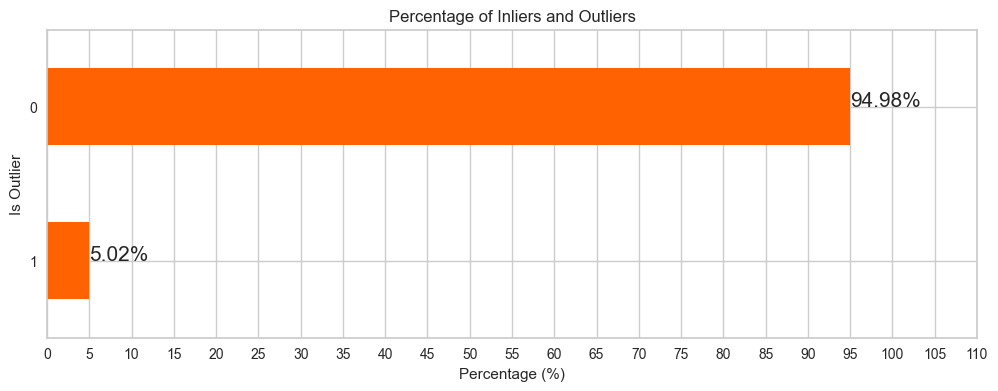

In [48]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [49]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [50]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

2725

## Correlation Analysis

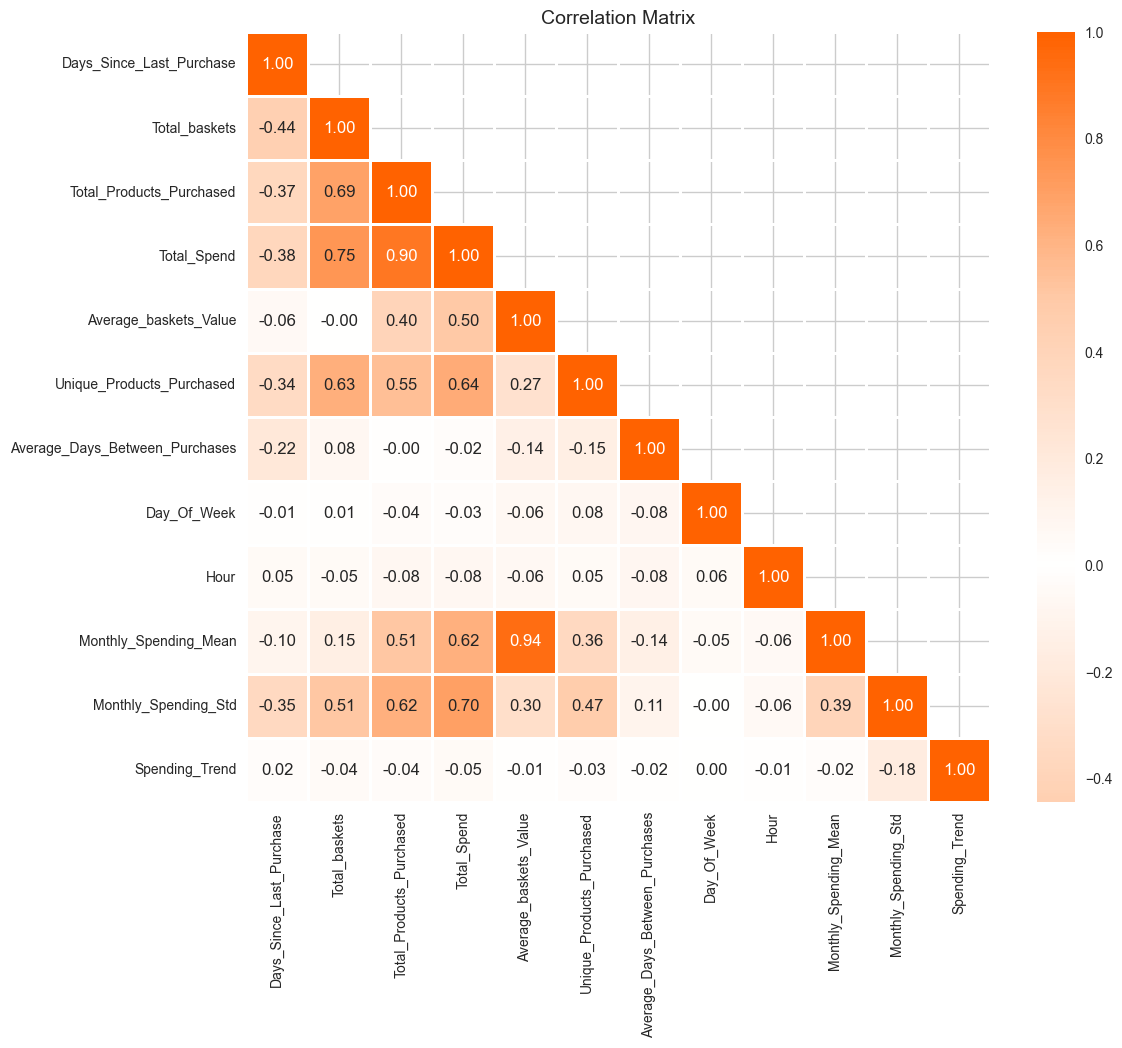

In [51]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Feature Scaling
- Standardize othe data, meaning transforming the features to have a mean of 0 and a standard deviation of 1
- Not all features require scaling:

1. CustomerID: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.
2. Day_Of_Week: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.


In [52]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12347.0,-0.829929,0.853878,0.555904,0.670186,-0.001133,0.759490,0.087239,1,0.661298,-0.124550,1.365556,-0.967873
1,12350.0,1.590722,-0.688338,-0.573997,-0.737899,-0.839711,-0.886193,-0.487024,2,1.523105,-0.870659,-0.662285,0.074343
2,12352.0,0.948781,0.468324,-0.264360,-0.349298,-0.756923,-0.474772,-0.250026,1,1.523105,-0.335746,0.040813,1.030807
3,12354.0,0.547568,-0.688338,0.251700,0.378947,3.868063,0.759490,-0.487024,3,0.230395,3.317990,-0.662285,0.074343
4,12355.0,0.306841,-0.688338,-0.628319,-0.502304,0.153381,-0.721624,-0.487024,0,0.230395,0.012925,-0.662285,0.074343


## Dimensionality Reduction

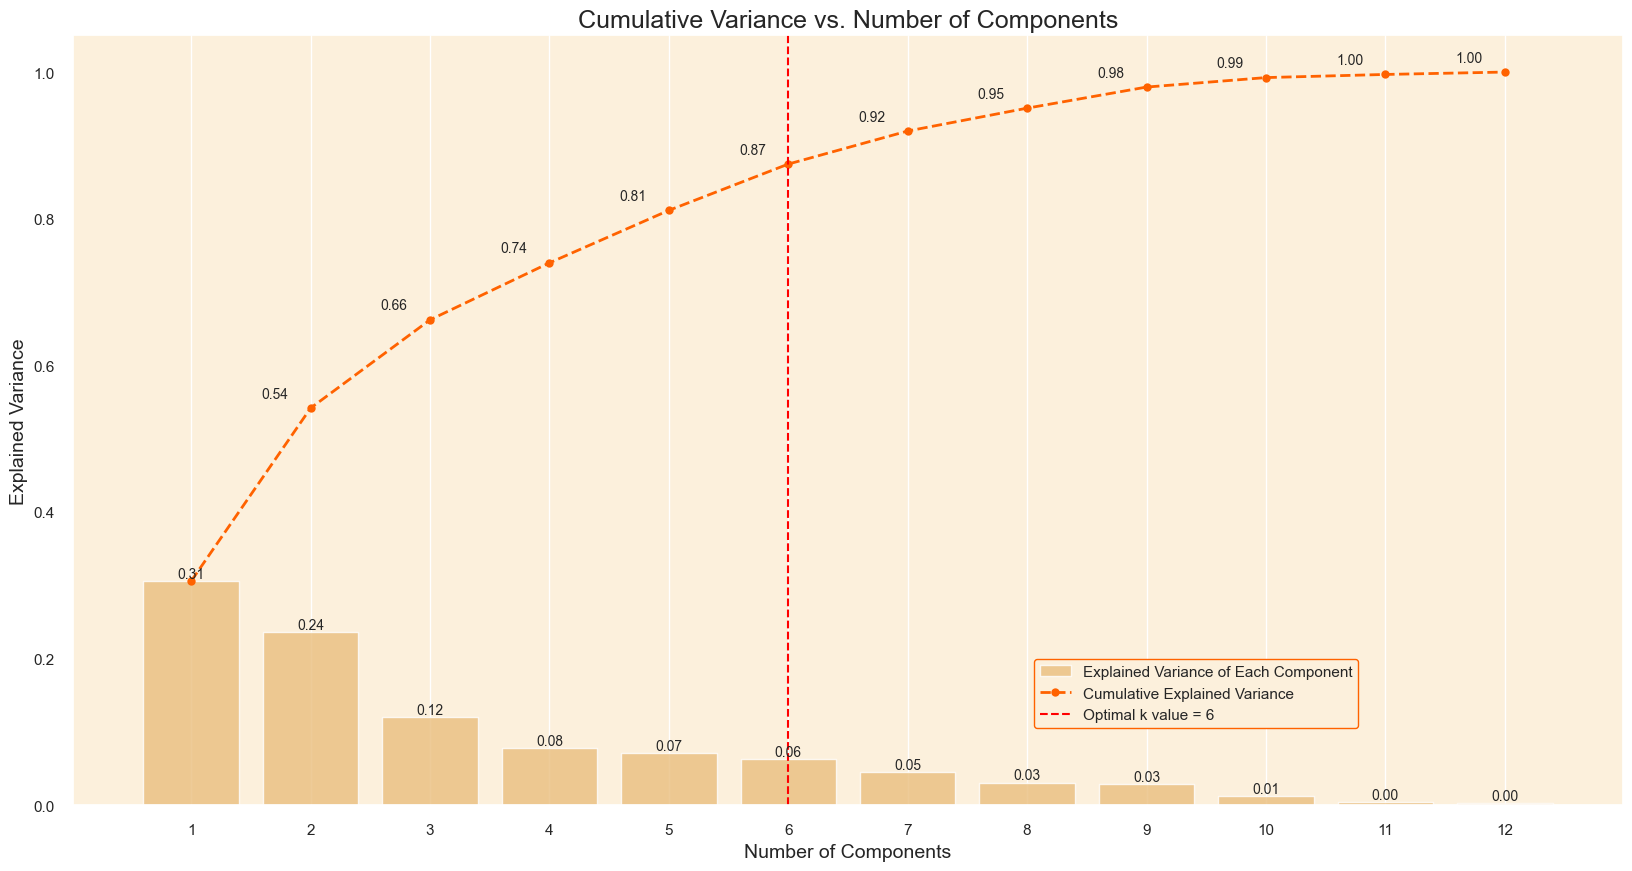

In [53]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [54]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [55]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12347.0,1.840320,-1.327526,-1.087450,0.607921,-1.111461,0.276837
12350.0,-2.277072,-0.566650,0.297223,1.471838,-0.440839,0.400756
12352.0,-0.812957,-1.457059,-0.271980,1.631302,0.511168,0.723234
12354.0,2.047404,0.305501,4.501155,-0.615668,0.090223,1.026625
12355.0,-1.122237,-2.612332,0.714073,0.398577,-0.029911,0.041387


In [56]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.228142,-0.024151,0.358968,0.142324,-0.085738,-0.238742
Total_baskets,0.349964,0.045631,-0.378088,0.173950,0.078978,-0.153517
Total_Products_Purchased,0.422879,0.009749,-0.057354,0.026809,0.055771,-0.052513
Total_Spend,0.456074,0.017172,-0.012964,0.026976,0.035493,-0.038955
Average_baskets_Value,0.274610,-0.034215,0.561836,-0.201008,-0.003329,0.191524
Unique_Products_Purchased,0.347318,0.081969,-0.083152,0.324555,0.047009,-0.108796
Average_Days_Between_Purchases,-0.006915,-0.059039,-0.359436,-0.585640,-0.005761,0.530251
Day_Of_Week,-0.053496,0.991198,0.044267,-0.103887,0.004252,0.018493
Hour,-0.040842,0.045755,0.018128,0.633129,-0.233740,0.721902
Monthly_Spending_Mean,0.325708,-0.020565,0.504038,-0.156800,-0.002904,0.156566


## K-means Clustering:
### Chose the number of clusters : Silhouette Method
An approach to find the optimal number of clusters in a dataset by evaluating the consistency within clusters and their separation from other clusters. It computes the silhouette coefficient for each data point, which measures how similar a point is to its own cluster compared to other clusters.

In [57]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

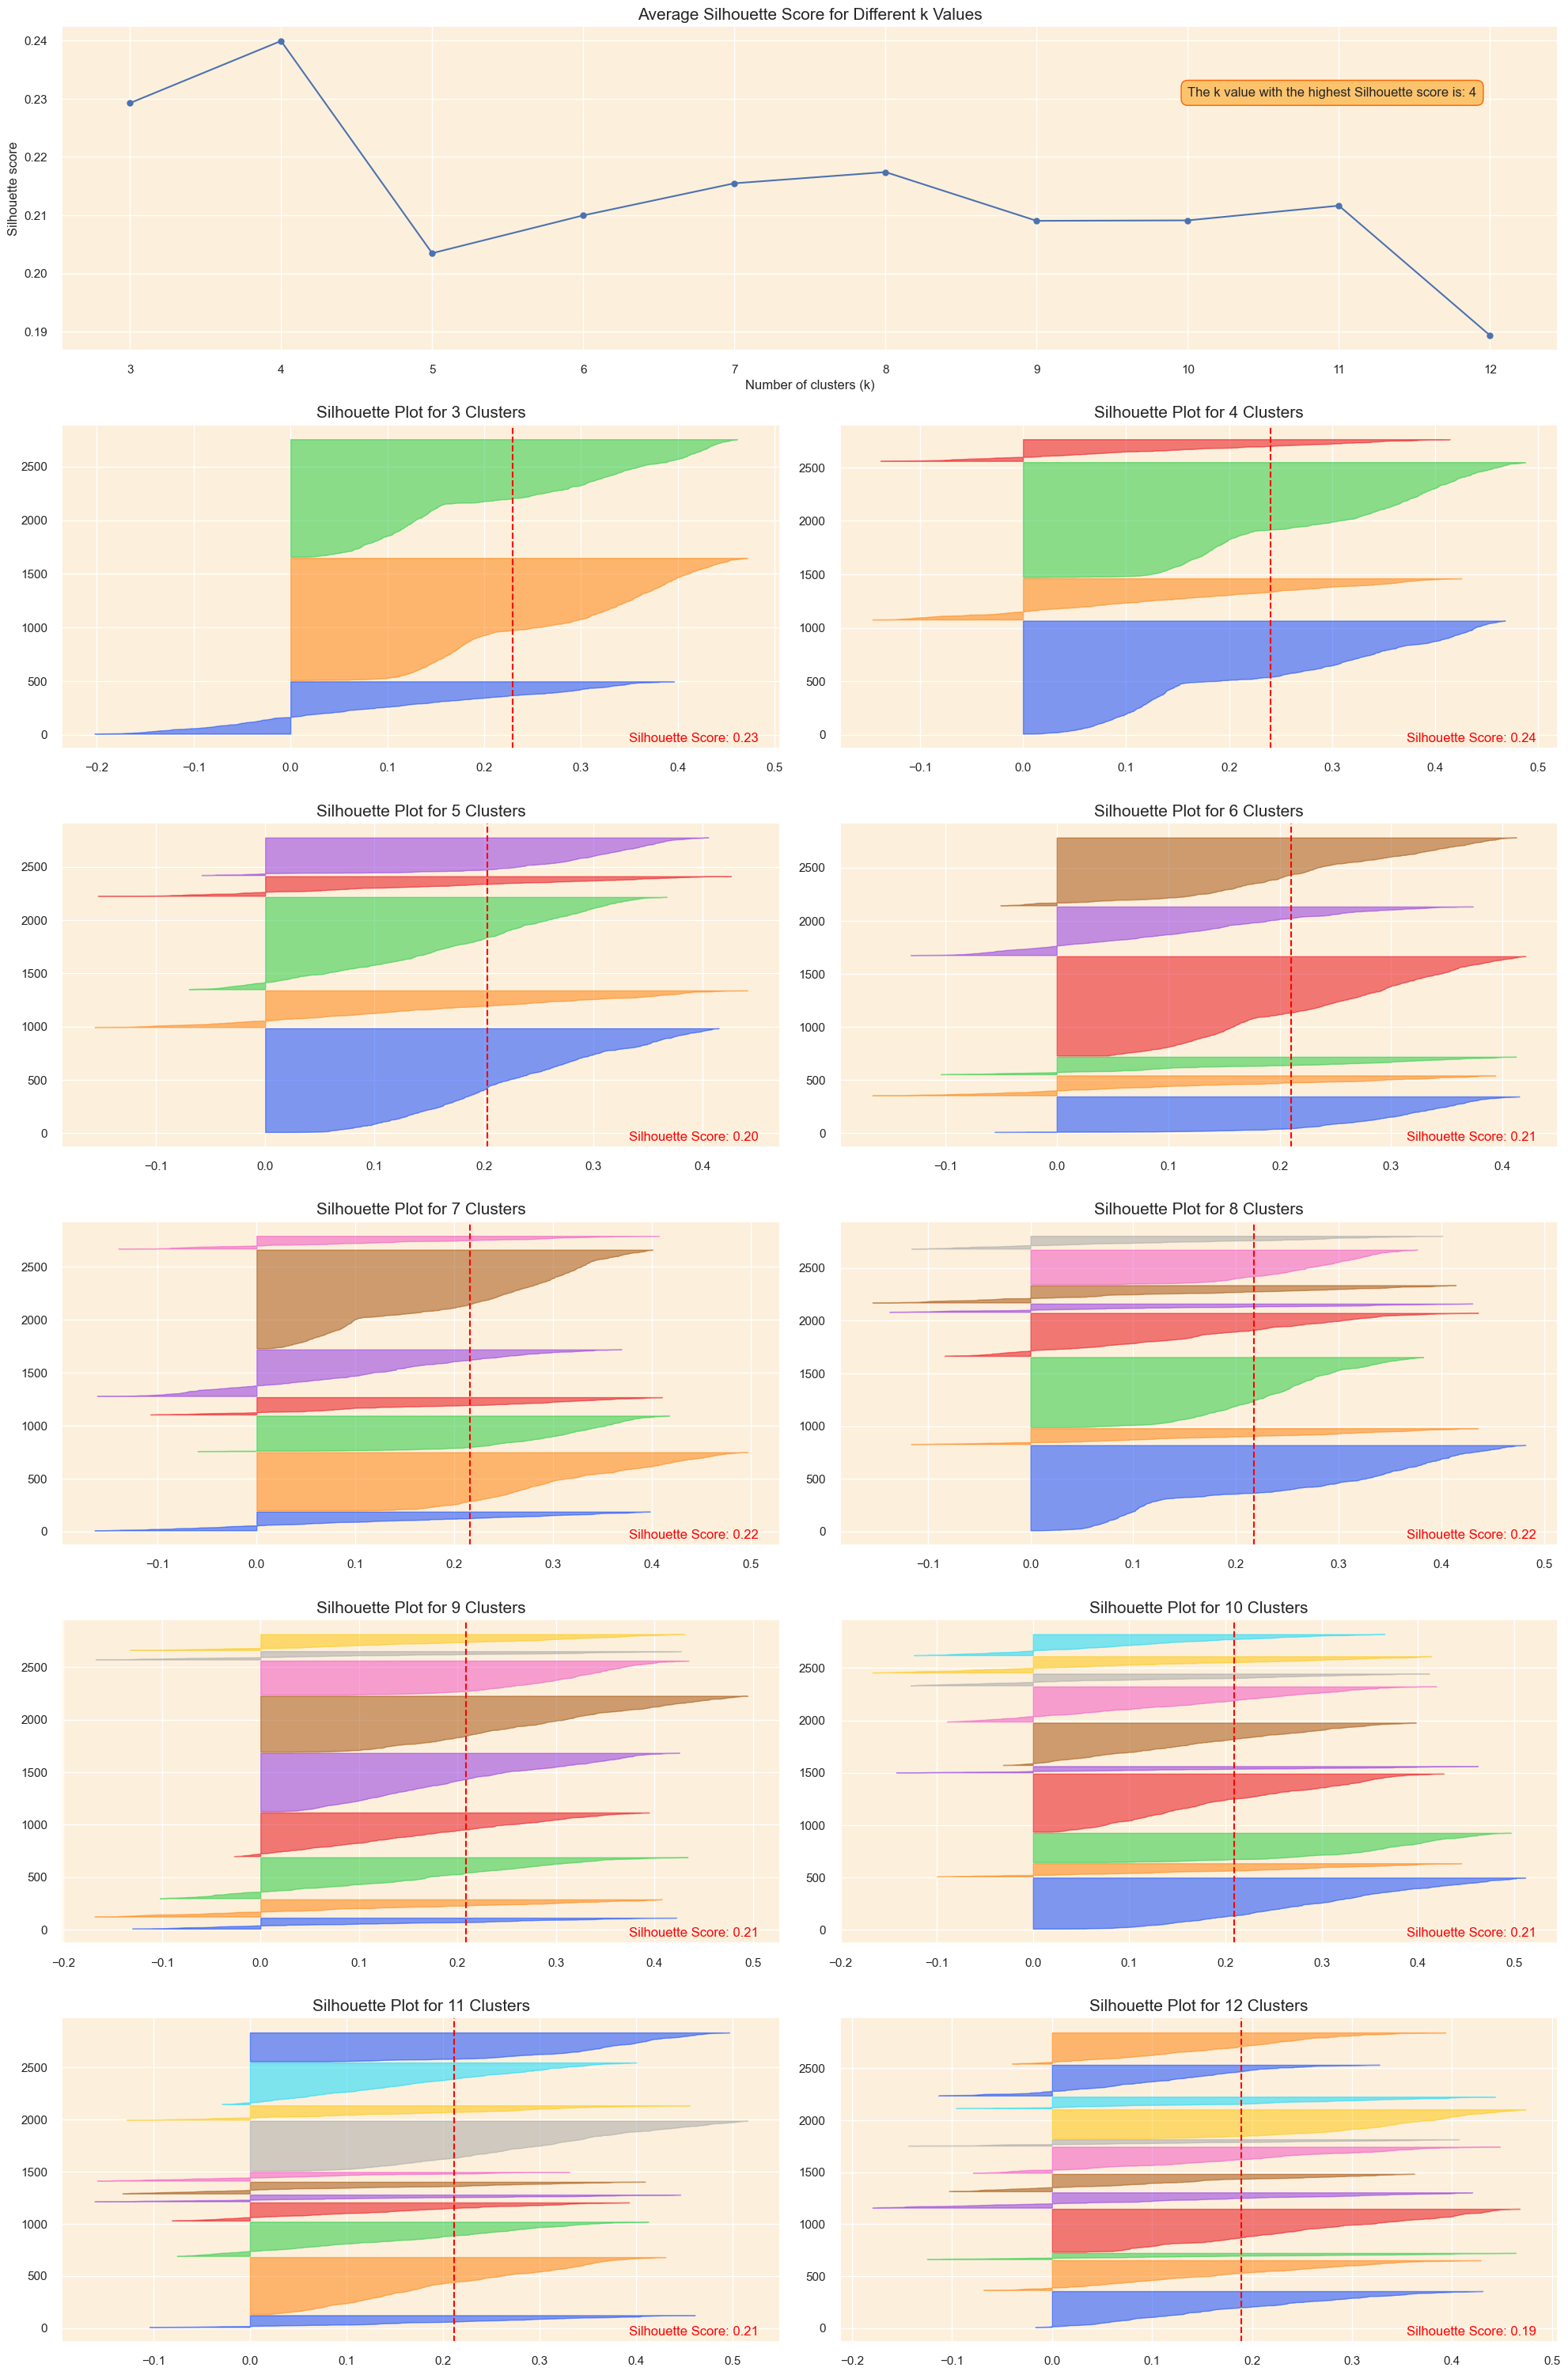

In [58]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

After carefully considering the silhouette plots, it's clear that choosing ( k = 3 ) is the better option.

## Clustering Model - K-means

In [59]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)

# Start timing
start_time = time.time()

kmeans.fit(customer_data_pca)

# End timing
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [60]:
print(f"Training time: {training_time:.4f} seconds")

Training time: 0.0379 seconds


In [61]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12347.0,29,5,244,517.72,103.544,22,9.153846,1,14,103.544,106.273336,-56.782,1
1,12350.0,210,1,36,35.4,35.4,2,0.0,2,16,35.4,0.0,0.0,2
2,12352.0,162,4,93,168.51,42.1275,7,3.777778,1,16,84.255,36.847334,52.11,2
3,12354.0,132,1,188,417.96,417.96,22,0.0,3,13,417.96,0.0,0.0,1
4,12355.0,114,1,26,116.1,116.1,4,0.0,0,13,116.1,0.0,0.0,2


## Cluster Distribution Visualization

The percentage of customers in each cluster, which helps in understanding if the clusters are balanced and significant:

In [62]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

C:\Users\pretil\AppData\Local\Temp\ipykernel_24680\1531732811.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)


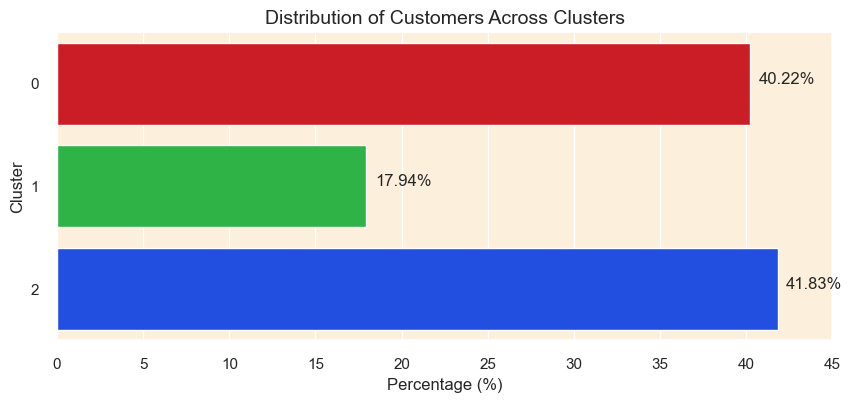

In [63]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

## Evaluation Metrics

Silhouette Score: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation.

Calinski Harabasz Score: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters

Davies Bouldin Score: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.


In [64]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        2725        |
|    Silhouette Score     | 0.2292607922843708 |
| Calinski Harabasz Score | 859.8864085563969  |
|  Davies Bouldin Score   | 1.3928756802958604 |
+-------------------------+--------------------+


## Cluster Analysis and Profiling

Analyze the characteristics of each cluster to understand the distinct behaviors and preferences of different customer segments

### Radar Chart Approach

Create radar charts to visualize the centroid values of each cluster across different features. This can give a quick visual comparison of the profiles of different clusters.

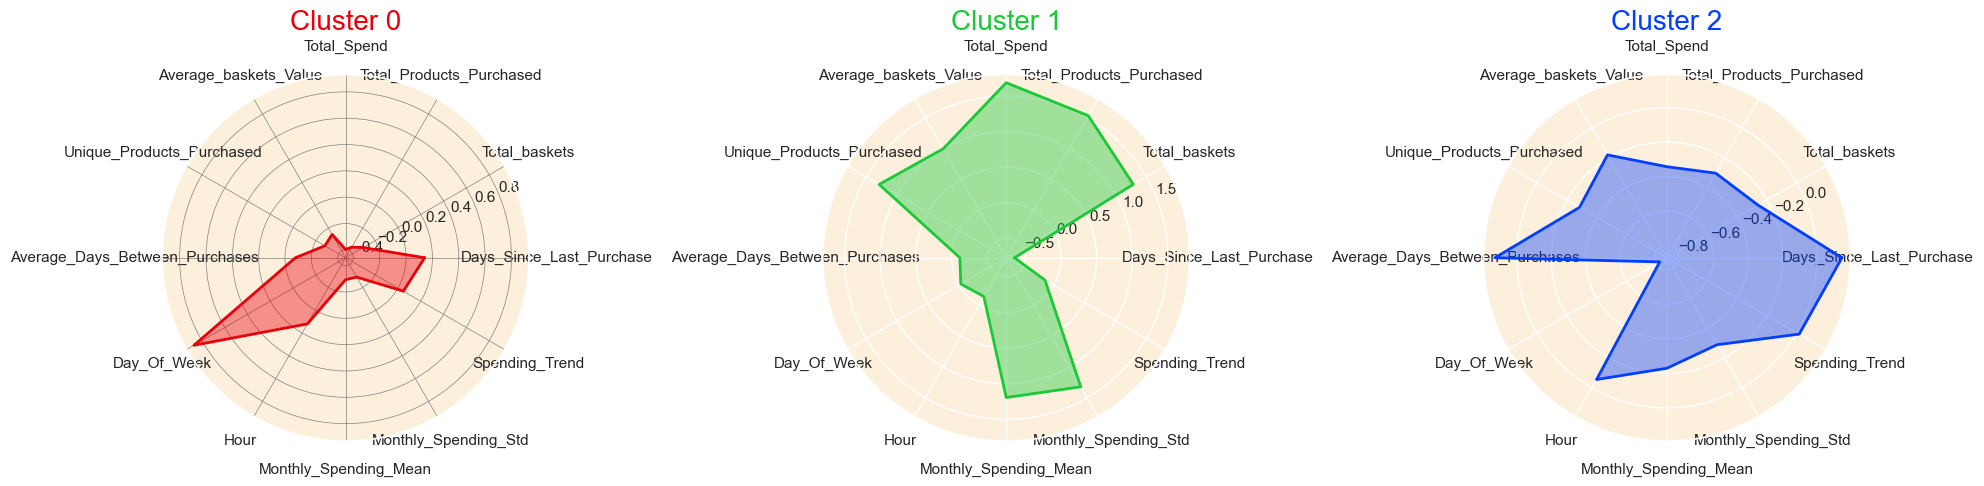

In [65]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

### Customer Profiles Derived from Radar Chart Analysis

**Cluster 0 (Red Chart): Frequent High-Spenders**  
- Very high total spending  
- Purchase a wide variety of unique products  
- Shop frequently with a very low average time between purchases  
- Tend to shop early in the day (low Hour value)  
- Monthly spending shows high variability, indicating less predictable patterns  
- Despite high spending, exhibit a declining spending trend over time  

---

**Cluster 1 (Green Chart): Sporadic Shoppers with a Preference for Weekend Shopping**  
- Generally lower spending overall  
- Fewer store visits and products purchased  
- Strong tendency to shop on weekends (high Day_of_Week value)  
- Spending trend is relatively stable but low  
- Low monthly spending variability  
- Lower average basket value, indicating smaller purchases  

---

**Cluster 2 (Blue Chart): Infrequent Big Spenders with a High Spending Trend**  
- Moderate spending frequency  
- Make substantial purchases when shopping (high average basket value)  
- Strongly increasing spending trend over time  
- Prefer shopping later in the day  


## Recommendation System

Now we are going to build the recommnendation system based:

The system will craft personalized recommendations, suggesting the top three products popular within the customer's cluster that they have not yet purchased.

In [66]:
# Step 1: Extract the CustomerIDs of the outliers and remove their baskets from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df_diy[~df_diy['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the baskets data with the customer data to get the cluster information for each basket
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()

best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [67]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
15752.0,21212,pack of 72 retrospot cake cases,85123A,white hanging heart t-light holder,84755,colour glass t-light holder hanging
14206.0,85123A,white hanging heart t-light holder,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging
13548.0,85123A,white hanging heart t-light holder,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging
15708.0,85099B,jumbo bag red retrospot,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging
17373.0,85123A,white hanging heart t-light holder,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging
14323.0,21212,pack of 72 retrospot cake cases,85123A,white hanging heart t-light holder,85099B,jumbo bag red retrospot
16498.0,85123A,white hanging heart t-light holder,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging
16940.0,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging,71459,hanging jam jar t-light holder
14221.0,85099B,jumbo bag red retrospot,21212,pack of 72 retrospot cake cases,84755,colour glass t-light holder hanging


## System evaluation using metrics

### Check for New Customers and Exclude Them from the Future Dataset

Since our goal is to recommend articles when a customer scans their loyalty card, this implies that all future customers should already exist in the past data. 

This aligns with the recommendation system we are building, which relies on previous customer behavior to suggest relevant articles. Therefore, new (previously unseen) customers should be excluded from the future dataset.

In [68]:
# Step 1: Make sure both columns are float (to avoid mismatches like 12347.0 vs "12347")
customer_data_with_recommendations['CustomerID'] = customer_data_with_recommendations['CustomerID'].astype(float)
df_future['CustomerID'] = df_future['CustomerID'].astype(float)

# Step 2: Extract unique CustomerIDs
past_customers = set(customer_data_with_recommendations['CustomerID'].dropna().unique())
future_customers = set(df_future['CustomerID'].dropna().unique())

# Step 3: Compare sets
returning_customers = future_customers.intersection(past_customers)
new_customers = future_customers.difference(past_customers)

# Step 4: Count
print("🔁 Number of returning customers:", len(returning_customers))
print("🆕 Number of new customers:", len(new_customers))
print("📊 Total future customers:", len(future_customers))

🔁 Number of returning customers: 1589
🆕 Number of new customers: 1151
📊 Total future customers: 2740


In [69]:
# Future transactions by returning customers
df_future_returning = df_future[df_future['CustomerID'].isin(returning_customers)]

In [70]:
df_future_returning

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,BasketID,ScanID
320713,565083,23146,triple hook antique ivory rose,16,2011-09-01 09:19:00,3.29,16187.0,United Kingdom,565083,16187.0_565083
320718,565083,22653,button box,20,2011-09-01 09:19:00,1.95,16187.0,United Kingdom,565083,16187.0_565083
320721,565083,22212,four hook white lovebirds,6,2011-09-01 09:19:00,2.10,16187.0,United Kingdom,565083,16187.0_565083
320726,565084,22659,lunch box i love london,64,2011-09-01 09:39:00,1.65,17306.0,United Kingdom,565084,17306.0_565084
320743,565088,22095,lads only tissue box,36,2011-09-01 10:11:00,0.39,16145.0,United Kingdom,565088,16145.0_565088
...,...,...,...,...,...,...,...,...,...,...
541883,581585,84692,box of 24 cocktail parasols,25,2011-12-09 12:31:00,0.42,15804.0,United Kingdom,581585,15804.0_581585
541888,581585,23145,zinc t-light holder star large,12,2011-12-09 12:31:00,0.95,15804.0,United Kingdom,581585,15804.0_581585
541894,581587,22631,circus parade lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,581587,12680.0_581587
541902,581587,22629,spaceboy lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,581587,12680.0_581587


## 🧺 Basket-Based Evaluation

We aim to evaluate the effectiveness of our product recommendations using a basket-level approach.

### 🎯 Objective

For each future **basket** (`BasketID`), check whether the customer purchased **at least one of the top 3 recommended products**.

This becomes a **binary classification task** per basket:

- **Hit (1)**: At least one recommended product is purchased in the basket.
- **Miss (0)**: None of the recommended products are purchased.

### 📊 Metrics to Compute

- **Hit Rate**  
  Proportion of baskets with at least one hit:  
  `Hit Rate = Number of Hits / Total Number of Baskets`

- **Baseline Rate**  
  Frequency at which a randomly selected product would match a purchase (used for comparison).

- **Lift**  
  Improvement over baseline:  
  `Lift = Hit Rate / Baseline Rate`

- **Statistical Significance (p-value)**  
  Use statistical tests (e.g., Chi-squared test or Fisher’s exact test) to evaluate whether the lift is significant.


In [71]:
# first Expand recommendations
recommendation_records = []

for _, row in customer_data_with_recommendations.iterrows():
    for i in range(1, 4):
        stockcode = row[f'Rec{i}_StockCode']
        if pd.notnull(stockcode):
            recommendation_records.append({
                'CustomerID': row['CustomerID'],
                'cluster': row['cluster'],
                'StockCode': stockcode
            })

recommendations_flat = pd.DataFrame(recommendation_records)

In [72]:
recommendations_flat

,CustomerID,cluster,StockCode
0,12361.0,0,85123A
1,12361.0,0,21212
2,12361.0,0,84755
3,12362.0,0,85123A
4,12362.0,0,21212
...,...,...,...
8170,18265.0,2,85099B
8171,18265.0,2,84755
8172,18280.0,2,21212
8173,18280.0,2,85123A


In [73]:
# Prepare future purchases with BasketID
future_baskets = df_future_returning[['BasketID', 'CustomerID', 'StockCode']].drop_duplicates()

In [74]:
future_baskets

,BasketID,CustomerID,StockCode
320713,565083,16187.0,23146
320718,565083,16187.0,22653
320721,565083,16187.0,22212
320726,565084,17306.0,22659
320743,565088,16145.0,22095
...,...,...,...
541883,581585,15804.0,84692
541888,581585,15804.0,23145
541894,581587,12680.0,22631
541902,581587,12680.0,22629


In [75]:
# Check hits per basket

# Merge recommendations with future baskets
basket_matches = future_baskets.merge(recommendations_flat, on=['CustomerID', 'StockCode'], how='left', indicator=True)

# Mark which basket lines are hits
basket_matches['is_hit'] = (basket_matches['_merge'] == 'both').astype(int)

# Now, check if ANY recommended product was purchased per BasketID
basket_hits = basket_matches.groupby(['BasketID', 'CustomerID'])['is_hit'].max().reset_index()

In [76]:
basket_hits

,BasketID,CustomerID,is_hit
0,565083,16187.0,0
1,565084,17306.0,0
2,565088,16145.0,0
3,565090,17572.0,0
4,565091,16011.0,0
...,...,...,...
3441,581567,16626.0,0
3442,581570,12662.0,0
3443,581579,17581.0,0
3444,581585,15804.0,0


## Recall@K

Recall at K measures the proportion of correctly identified relevant items in the top K recommendations out of the total number of relevant items in the dataset. In simpler terms, it indicates how many of the relevant items you could successfully find.

In [77]:
# Step 1: Get actual items per basket (ground truth)
ground_truth = future_baskets.groupby(['BasketID', 'CustomerID'])['StockCode'].apply(set).reset_index(name='true_items')

# Step 2: Get predicted items per user (flattened per user)
recommended_items = recommendations_flat.groupby('CustomerID')['StockCode'].apply(list).reset_index(name='predicted_items')

# Step 3: Join ground truth and predictions
evaluation_df = ground_truth.merge(recommended_items, on='CustomerID', how='left')

# Step 4: Compute Recall@K
def recall_at_k(true_items, predicted_items, k=3):
    if not predicted_items:
        return 0.0
    hits = len(set(predicted_items[:k]) & set(true_items))
    return hits / len(true_items) if true_items else 0.0

evaluation_df['Recall@3'] = evaluation_df.apply(lambda row: recall_at_k(row['true_items'], row['predicted_items'], k=3), axis=1)


In [78]:
evaluation_df

,BasketID,CustomerID,true_items,predicted_items,Recall@3
0,565083,16187.0,"{23146, 22212, 22653}","[85123A, 84755, 22197]",0.0
1,565084,17306.0,{22659},"[21212, 85123A, 85099B]",0.0
2,565088,16145.0,"{23298, 85123A, 21231, 22095, 21232, 20914, 23...","[85099B, 84755, 20725]",0.0
3,565090,17572.0,{21107},"[21212, 85123A, 85099B]",0.0
4,565091,16011.0,"{21668, 21670, 23032, 23034, 23035}","[85099B, 85123A, 21212]",0.0
...,...,...,...,...,...
3441,581567,16626.0,"{22464, 22465, 21326, 21137, 84971S}","[85123A, 22197, 20724]",0.0
3442,581570,12662.0,"{21914, 22139, 22326, 20750}","[85099B, 85123A, 21212]",0.0
3443,581579,17581.0,"{22083, 21931, 23319, 22197, 23318, 23350}","[85123A, 84755, 71459]",0.0
3444,581585,15804.0,"{84945, 84692, 22460, 23145}","[85123A, 21212, 84755]",0.0


## Normalized Discounted Cumulative Gain (NDCG)
Ranking quality metric. It compares rankings to an ideal order where all relevant items are at the top of the list.

NDCG can take values from 0 to 1, where 1 indicates a match with the ideal order, and lower values represent a lower quality of ranking.

In [79]:
def ndcg_at_k(true_items, predicted_items, k=3):
    dcg = 0.0
    for i, item in enumerate(predicted_items[:k]):
        if item in true_items:
            dcg += 1 / np.log2(i + 2)  # i+2 because log2(1) = 0
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_items), k)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

evaluation_df['NDCG@3'] = evaluation_df.apply(lambda row: ndcg_at_k(row['true_items'], row['predicted_items'], k=3), axis=1)

In [80]:
evaluation_df

,BasketID,CustomerID,true_items,predicted_items,Recall@3,NDCG@3
0,565083,16187.0,"{23146, 22212, 22653}","[85123A, 84755, 22197]",0.0,0.0
1,565084,17306.0,{22659},"[21212, 85123A, 85099B]",0.0,0.0
2,565088,16145.0,"{23298, 85123A, 21231, 22095, 21232, 20914, 23...","[85099B, 84755, 20725]",0.0,0.0
3,565090,17572.0,{21107},"[21212, 85123A, 85099B]",0.0,0.0
4,565091,16011.0,"{21668, 21670, 23032, 23034, 23035}","[85099B, 85123A, 21212]",0.0,0.0
...,...,...,...,...,...,...
3441,581567,16626.0,"{22464, 22465, 21326, 21137, 84971S}","[85123A, 22197, 20724]",0.0,0.0
3442,581570,12662.0,"{21914, 22139, 22326, 20750}","[85099B, 85123A, 21212]",0.0,0.0
3443,581579,17581.0,"{22083, 21931, 23319, 22197, 23318, 23350}","[85123A, 84755, 71459]",0.0,0.0
3444,581585,15804.0,"{84945, 84692, 22460, 23145}","[85123A, 21212, 84755]",0.0,0.0


## Mean Average Precision (MAP)

It measures both the relevance of suggested items and how good the system is at placing more relevant items at the top.


In [81]:
def average_precision_at_k(true_items, predicted_items, k=3):
    score = 0.0
    hits = 0
    for i, item in enumerate(predicted_items[:k]):
        if item in true_items:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(true_items), k) if true_items else 0.0

evaluation_df['MAP@3'] = evaluation_df.apply(lambda row: average_precision_at_k(row['true_items'], row['predicted_items'], k=3), axis=1)

In [82]:
evaluation_df

,BasketID,CustomerID,true_items,predicted_items,Recall@3,NDCG@3,MAP@3
0,565083,16187.0,"{23146, 22212, 22653}","[85123A, 84755, 22197]",0.0,0.0,0.0
1,565084,17306.0,{22659},"[21212, 85123A, 85099B]",0.0,0.0,0.0
2,565088,16145.0,"{23298, 85123A, 21231, 22095, 21232, 20914, 23...","[85099B, 84755, 20725]",0.0,0.0,0.0
3,565090,17572.0,{21107},"[21212, 85123A, 85099B]",0.0,0.0,0.0
4,565091,16011.0,"{21668, 21670, 23032, 23034, 23035}","[85099B, 85123A, 21212]",0.0,0.0,0.0
...,...,...,...,...,...,...,...
3441,581567,16626.0,"{22464, 22465, 21326, 21137, 84971S}","[85123A, 22197, 20724]",0.0,0.0,0.0
3442,581570,12662.0,"{21914, 22139, 22326, 20750}","[85099B, 85123A, 21212]",0.0,0.0,0.0
3443,581579,17581.0,"{22083, 21931, 23319, 22197, 23318, 23350}","[85123A, 84755, 71459]",0.0,0.0,0.0
3444,581585,15804.0,"{84945, 84692, 22460, 23145}","[85123A, 21212, 84755]",0.0,0.0,0.0


In [83]:
# Overall averages
evaluation_df[['Recall@3', 'NDCG@3', 'MAP@3']].mean()


Recall@3    0.016193
NDCG@3      0.029792
MAP@3       0.020837
dtype: float64

## Total lift

In [84]:
def random_hit_prob (future_baskets):
    # Total unique products
    total_unique_products = future_baskets['StockCode'].nunique()

    # Average number of items per basket
    avg_items_per_basket = future_baskets.groupby(['BasketID', 'CustomerID'])['StockCode'].nunique().mean()

    # Probability of hitting a relevant item by chance
    return avg_items_per_basket / total_unique_products

In [85]:
def hits_at_k(true_items, predicted_items, k=3):
    if not predicted_items:
        return 0
    return len(set(predicted_items[:k]) & set(true_items))

evaluation_df['Hits@3'] = evaluation_df.apply(lambda row: hits_at_k(row['true_items'], row['predicted_items'], k=3), axis=1)


In [86]:
evaluation_df['RandomHits@3'] = evaluation_df['true_items'].apply(lambda true: len(true) * random_hit_prob(future_baskets))

In [87]:
# Avoid division by zero
evaluation_df['Lift@3'] = evaluation_df.apply(
    lambda row: (row['Hits@3'] / row['RandomHits@3']) if row['RandomHits@3'] > 0 else 0.0, axis=1
)


## P_value

In [88]:


def compute_lift_p_value(evaluation_df, future_baskets, k=3):
    """
    Compute p-value for Lift@K using a one-sided proportions z-test.

    Parameters:
    - evaluation_df: DataFrame with 'Hits@K' column for each basket.
    - future_baskets: Ground truth data used to estimate the random hit probability.
    - k: Top-K used for recommendations.

    Returns:
    - p-value (float)
    """
    # Compute baseline hit probability using your function
    baseline_rate = random_hit_prob(future_baskets)

    # Number of hits: baskets where Hits@K > 0
    hit_count = (evaluation_df[f'Hits@{k}'] > 0).sum()

    # Total number of baskets
    total_baskets = len(evaluation_df)

    # Proportions z-test: is observed hit rate significantly greater than baseline?
    stat, p_value = proportions_ztest(
        count=hit_count,
        nobs=total_baskets,
        value=baseline_rate,
        alternative='larger'  # One-sided test: model > random
    )

    return p_value


In [89]:
p_val = compute_lift_p_value(evaluation_df, future_baskets, k=3)
print(f"Lift@3 p-value (z-test): {p_val:.5f}")


Lift@3 p-value (z-test): 0.00000


In [90]:
# Overall averages
evaluation_df[['Recall@3', 'NDCG@3', 'MAP@3', 'Lift@3']].mean()

Recall@3    0.016193
NDCG@3      0.029792
MAP@3       0.020837
Lift@3      1.890330
dtype: float64

## Matrix factorization

In [91]:
# Use the original dataset
df = df_diy.copy()

# Create a binary interaction (1 if bought at least once)
interaction_df = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
interaction_df['interaction'] = 1  # You can use quantity or total spend instead

# Pivot to get user-item matrix
user_item_matrix = interaction_df.pivot(index='CustomerID', columns='StockCode', values='interaction').fillna(0)

# Convert all column names to strings
user_item_matrix.columns = user_item_matrix.columns.astype(str)

In [92]:
user_item_matrix

StockCode,15030,17038,17096,20658,20665,20676,20682,20685,20700,20701,...,85086A,85099B,85123A,85124B,85124C,85167B,85184C,85206A,85206B,90030A
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# Initialize SVD with desired number of latent factors
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Start timing
start_time = time.time()

# Fit the SVD model
latent_matrix = svd.fit_transform(user_item_matrix)

# Get latent factors
customer_factors = pd.DataFrame(latent_matrix, index=user_item_matrix.index)
item_factors = pd.DataFrame(svd.components_.T, index=user_item_matrix.columns)

# Dot product to get predicted preference scores
score_matrix = np.dot(customer_factors.values, item_factors.values.T)

# Create a DataFrame for predicted scores
score_df = pd.DataFrame(score_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)

# End timing
end_time = time.time()

# Calculate training time
training_time = end_time - start_time


In [94]:
print(f"Training time: {training_time:.4f} seconds")

Training time: 0.0676 seconds


In [95]:
score_df

StockCode,15030,17038,17096,20658,20665,20676,20682,20685,20700,20701,...,85086A,85099B,85123A,85124B,85124C,85167B,85184C,85206A,85206B,90030A
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,-0.001786,0.000631,-0.000516,-0.003582,-0.000142,0.017338,-0.008715,-0.021800,-0.001741,-0.000485,...,-0.000412,-0.002558,-0.005909,0.001426,0.000754,-0.000439,0.005040,-0.006000,-0.000086,0.000566
12347.0,0.006156,0.022161,0.030498,0.051101,0.060740,0.087819,0.058527,0.121255,0.010472,0.005667,...,0.020403,-0.051269,-0.067283,0.014417,0.024717,0.024838,0.113853,0.030209,0.008643,0.011417
12348.0,0.000875,0.001337,0.000635,0.005594,0.006412,-0.000312,0.004844,0.018532,0.000857,0.000902,...,0.000065,-0.015682,-0.008233,0.000725,0.001272,0.001088,0.010504,-0.001780,-0.000541,0.000156
12350.0,-0.002140,-0.000568,0.001895,0.007250,-0.004009,-0.022643,0.013467,0.022109,-0.001724,-0.002146,...,0.000244,0.015462,0.043541,0.007249,0.004828,-0.002587,-0.000493,0.011687,0.000649,0.000448
12352.0,-0.002065,0.010423,0.009575,-0.006649,0.021375,-0.029255,-0.000771,-0.207253,-0.001741,0.000406,...,0.002045,-0.079078,0.080123,0.023534,0.013480,-0.001726,0.048203,0.032513,-0.002010,0.004350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.002454,0.003926,0.003289,0.010809,0.012753,0.015168,0.014209,0.050170,0.000615,0.000864,...,0.000336,-0.006731,-0.022563,0.002138,0.004728,0.002791,0.020864,0.005138,-0.000030,0.000131
18281.0,0.002645,0.004009,0.003343,0.011335,0.011967,0.009727,0.015410,0.054169,0.000550,0.000950,...,0.000119,-0.001000,-0.021591,0.002094,0.005014,0.003024,0.022132,0.003492,0.000058,-0.000286
18282.0,0.001628,0.002256,0.001143,0.005805,0.000235,-0.010469,-0.005184,-0.019136,0.001508,0.000280,...,0.001806,0.003084,-0.000098,0.001821,0.003577,0.001494,0.009679,0.003093,0.000092,0.000783


In [96]:
def get_top_k_recommendations(customer_id, score_df, k=3):
    """
    Get top-k recommendations for a customer.
    
    Args:
        customer_id: Customer identifier
        score_df: DataFrame of recommendation scores (customers x items)
        k: Number of recommendations to return
    Returns:
        List of recommended StockCodes
    """
    try:
        # Get scores for this customer
        customer_scores = score_df.loc[customer_id]
        
        # Return top-k recommendations
        return customer_scores.sort_values(ascending=False).head(k).index.tolist()
    
    except KeyError:
        # Handle cases where customer isn't in the score matrix
        return []


In [97]:
# Example usage for a single basket
customer_id = 16187.0
basket_items = [565083]  # Items already in BasketID
recommendations = get_top_k_recommendations(customer_id, score_df, k=3)
print(recommendations)

['23298', '20725', '21212']


In [98]:
def generate_recommendations(future_baskets, score_df, k=3):
    # Group by BasketID and CustomerID to get items in each basket
    basket_groups = future_baskets.groupby(['BasketID', 'CustomerID'])['StockCode'].apply(list).reset_index()
    
    results = []
    
    for _, row in basket_groups.iterrows():
        basket_id = row['BasketID']
        customer_id = row['CustomerID']
        
        # Get recommendations (excluding basket items)
        recommended_items = get_top_k_recommendations(customer_id, score_df, k)
        
        results.append({
            'BasketID': basket_id,
            'CustomerID': customer_id,
            'RecommendedItems': recommended_items,
        })
    
    return pd.DataFrame(results)

# Generate recommendations for all baskets
recommendation_results = generate_recommendations(future_baskets, score_df, k=3)

# Display results
print(recommendation_results.head())

  BasketID  CustomerID        RecommendedItems
0   565083     16187.0   [23298, 20725, 21212]
1   565084     17306.0   [22629, 22630, 22631]
2   565088     16145.0  [85123A, 21212, 23298]
3   565090     17572.0   [22197, 22138, 21080]
4   565091     16011.0   [21668, 21671, 21669]


In [99]:
recommendation_results

,BasketID,CustomerID,RecommendedItems
0,565083,16187.0,"[23298, 20725, 21212]"
1,565084,17306.0,"[22629, 22630, 22631]"
2,565088,16145.0,"[85123A, 21212, 23298]"
3,565090,17572.0,"[22197, 22138, 21080]"
4,565091,16011.0,"[21668, 21671, 21669]"
...,...,...,...
3441,581567,16626.0,"[21671, 21668, 21669]"
3442,581570,12662.0,"[23298, 21238, 21242]"
3443,581579,17581.0,"[85099B, 21080, 21212]"
3444,581585,15804.0,"[23298, 22629, 22630]"


In [100]:

# Step 3: Join ground truth and predictions
evaluation_mf = ground_truth.merge(recommendation_results, on='CustomerID', how='left')

In [101]:
evaluation_mf

,BasketID_x,CustomerID,true_items,BasketID_y,RecommendedItems
0,565083,16187.0,"{23146, 22212, 22653}",565083,"[23298, 20725, 21212]"
1,565083,16187.0,"{23146, 22212, 22653}",568173,"[23298, 20725, 21212]"
2,565083,16187.0,"{23146, 22212, 22653}",571733,"[23298, 20725, 21212]"
3,565083,16187.0,"{23146, 22212, 22653}",574953,"[23298, 20725, 21212]"
4,565084,17306.0,{22659},565084,"[22629, 22630, 22631]"
...,...,...,...,...,...
11841,581585,15804.0,"{84945, 84692, 22460, 23145}",579194,"[23298, 22629, 22630]"
11842,581585,15804.0,"{84945, 84692, 22460, 23145}",581585,"[23298, 22629, 22630]"
11843,581587,12680.0,"{22138, 22629, 22631}",566256,"[22629, 22630, 22631]"
11844,581587,12680.0,"{22138, 22629, 22631}",568518,"[22629, 22630, 22631]"


In [102]:
evaluation_mf['Recall@3'] = evaluation_mf.apply(lambda row: recall_at_k(row['true_items'], row['RecommendedItems'], k=3), axis=1)

In [103]:
evaluation_mf['NDCG@3'] = evaluation_mf.apply(lambda row: ndcg_at_k(row['true_items'], row['RecommendedItems'], k=3), axis=1)

In [104]:
evaluation_mf['MAP@3'] = evaluation_mf.apply(lambda row: average_precision_at_k(row['true_items'], row['RecommendedItems'], k=3), axis=1)

In [105]:
evaluation_mf['Hits@3'] = evaluation_mf.apply(lambda row: hits_at_k(row['true_items'], row['RecommendedItems'], k=3), axis=1)

In [106]:
evaluation_mf['RandomHits@3'] = evaluation_mf['true_items'].apply(lambda true: len(true) * random_hit_prob(future_baskets))

In [107]:
evaluation_mf['Lift@3'] = evaluation_mf.apply(
    lambda row: (row['Hits@3'] / row['RandomHits@3']) if row['RandomHits@3'] > 0 else 0.0, axis=1
)

In [108]:
# Overall averages
evaluation_mf[['Recall@3', 'NDCG@3', 'MAP@3', 'Lift@3']].mean()

Recall@3    0.038544
NDCG@3      0.071667
MAP@3       0.051206
Lift@3      4.499522
dtype: float64

## Graph-based models

The available data might be better represented in a graph. GNNs can leverage both content information (user, item features) as well as graph structure (user-item interaction).

### Graph structure (Build the Bipart-graph)

In [109]:
# Use the original dataset
df = df_diy.copy()
df_customer_features = customer_data_scaled.copy()


In [110]:
# Ensure customer IDs are the same type
df['CustomerID'] = df['CustomerID'].astype(str)
df_customer_features.index = df_customer_features.index.astype(str)

# Filter df to only include customerIDs that are in df_customer_features
df = df[df['CustomerID'].isin(df_customer_features.index)]

In [111]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'BasketID', 'ScanID',
       'InvoiceDay', 'Total_Spend', 'Day_Of_Week', 'Hour', 'Year', 'Month'],
      dtype='object')

In [112]:
df_customer_features.columns

Index(['Days_Since_Last_Purchase', 'Total_baskets', 'Total_Products_Purchased',
       'Total_Spend', 'Average_baskets_Value', 'Unique_Products_Purchased',
       'Average_Days_Between_Purchases', 'Day_Of_Week', 'Hour',
       'Monthly_Spending_Mean', 'Monthly_Spending_Std', 'Spending_Trend'],
      dtype='object')

In [113]:
# Step 1: Create user and item index mappings
# Ensure CustomerID in basket_df is string (after converting from float to int)
df['CustomerID'] = df['CustomerID'].astype(float).astype(int).astype(str)
user_ids = df['CustomerID'].unique()
item_ids = df['StockCode'].unique()

In [114]:
# Only keep user_ids that exist in df_customer_features
valid_user_ids = [uid for uid in user_ids if uid in df_customer_features.index]

In [115]:
user2idx = {uid: i for i, uid in enumerate(user_ids)}
item2idx = {iid: i + len(user_ids) for i, iid in enumerate(item_ids)}  # item IDs start after user IDs

In [116]:
# Step 2: Build edge index (edges: user → item)
edge_index = []
for _, row in df.iterrows():
    if pd.notna(row['CustomerID']) and row['StockCode'] in item2idx:
        user_idx = user2idx[row['CustomerID']]
        item_idx = item2idx[row['StockCode']]
        edge_index.append([user_idx, item_idx])

In [117]:
# Convert to PyG format: [2, num_edges]
edge_index = torch.tensor(edge_index, dtype=torch.long).t()

In [118]:
edge_index.shape

torch.Size([2, 45653])

In [119]:
df_customer_features.index = df_customer_features.index.astype(float).astype(int).astype(str)
df_customer_features.index

Index(['12347', '12350', '12352', '12354', '12355', '12358', '12359', '12360',
       '12361', '12362',
       ...
       '18257', '18260', '18262', '18263', '18265', '18272', '18280', '18282',
       '18283', '18287'],
      dtype='object', name='CustomerID', length=2725)

In [120]:
df_customer_features

,Days_Since_Last_Purchase,Total_baskets,Total_Products_Purchased,Total_Spend,Average_baskets_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
CustomerID,,,,,,,,,,,,
12347,-0.829929,0.853878,0.555904,0.670186,-0.001133,0.759490,0.087239,1,0.661298,-0.124550,1.365556,-0.967873
12350,1.590722,-0.688338,-0.573997,-0.737899,-0.839711,-0.886193,-0.487024,2,1.523105,-0.870659,-0.662285,0.074343
12352,0.948781,0.468324,-0.264360,-0.349298,-0.756923,-0.474772,-0.250026,1,1.523105,-0.335746,0.040813,1.030807
12354,0.547568,-0.688338,0.251700,0.378947,3.868063,0.759490,-0.487024,3,0.230395,3.317990,-0.662285,0.074343
12355,0.306841,-0.688338,-0.628319,-0.502304,0.153381,-0.721624,-0.487024,0,0.230395,0.012925,-0.662285,0.074343
...,...,...,...,...,...,...,...,...,...,...,...,...
18272,-1.043909,0.468324,0.990481,0.847452,0.504224,1.006343,-0.241621,3,1.092201,0.852859,-0.034789,-0.432338
18280,1.149388,-0.688338,-0.726099,-0.738483,-0.842173,-0.886193,-0.487024,0,-1.493218,-0.872849,-0.662285,0.074343
18282,-0.870050,-0.688338,-0.497946,-0.761196,-0.937913,-0.886193,-0.487024,4,0.230395,-0.958032,-0.662285,0.074343


In [121]:
user_ids.shape

(2725,)

In [122]:
# Step 3: Build node features

# Ensure we align the DataFrame to match the order of user_ids

df_customer_features = df_customer_features.loc[user_ids]

# Convert Int32 to standard int (int64) and ensure all data is float
df_customer_features = df_customer_features.astype('float32')

# Now convert to torch tensor
x_user = torch.tensor(df_customer_features.values, dtype=torch.float)


In [123]:
x_user


tensor([[-0.8567,  1.6250,  0.5668,  ...,  0.3141,  0.8062,  0.3674],
        [-1.1375,  2.3961,  3.6414,  ...,  0.5176,  1.0356, -0.1745],
        [-0.2549,  2.7816,  2.9406,  ...,  2.7937,  1.1062,  0.8976],
        ...,
        [-1.2178, -0.6883, -0.6935,  ..., -0.9210, -0.6623,  0.0743],
        [-1.2178, -0.6883, -0.1503,  ...,  0.1483, -0.6623,  0.0743],
        [-1.2178, -0.6883, -0.6772,  ..., -0.8881, -0.6623,  0.0743]])

In [124]:
# Placeholder item features: zeros with same dimensionality
x_item = torch.zeros((len(item_ids), x_user.shape[1]), dtype=torch.float)

In [125]:
# Combine into a single feature matrix
x = torch.cat([x_user, x_item], dim=0)

In [126]:
# Step 4: Create PyG data object
data = Data(x=x, edge_index=edge_index)

# Done: The 'data' object is ready for GNN training (e.g. LightGCN, GCN, GraphSAGE)
print(data)

Data(x=[3506, 12], edge_index=[2, 45653])


In [127]:


class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


In [128]:
def bpr_loss(user_emb, pos_item_emb, neg_item_emb):
    pos_scores = (user_emb * pos_item_emb).sum(dim=1)
    neg_scores = (user_emb * neg_item_emb).sum(dim=1)
    
    # Clamp difference to avoid large exponentials
    diff = torch.clamp(pos_scores - neg_scores, min=-20, max=20)
    
    loss = -torch.log(torch.sigmoid(diff) + 1e-8).mean()
    return loss



In [129]:
num_users = len(user_ids)
num_items = len(item_ids)
num_nodes = num_users + num_items

user_indices = torch.arange(0, num_users)
item_indices = torch.arange(num_users, num_nodes)

# Build edge list as tensor
edge_index = data.edge_index
user_item_edges = edge_index.T  # shape [num_edges, 2]

# Only keep user→item edges
user_item_edges = user_item_edges[user_item_edges[:, 0] < num_users]


In [130]:
user2idx = {customer_id: idx for idx, customer_id in enumerate(user_ids)}
idx2user = {idx: customer_id for customer_id, idx in user2idx.items()}

item2idx = {item_id: idx for idx, item_id in enumerate(item_ids)}
idx2item = {idx: item_id for item_id, idx in item2idx.items()}

In [131]:
model = GCNModel(in_channels=12, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [132]:
for epoch in range(400):
    model.train()
    optimizer.zero_grad()

    embeddings = model(data.x, data.edge_index)
    user_emb = embeddings[:num_users]
    item_emb = embeddings[num_users:]

    # Sample a batch of user-item pairs
    idx = torch.randint(0, user_item_edges.size(0), (1024,))
    user_ids_batch = user_item_edges[idx][:, 0]
    pos_item_ids_batch = user_item_edges[idx][:, 1] - num_users

    # Sample negative items randomly
    neg_item_ids_batch = torch.randint(0, num_items, (len(user_ids_batch),))

    # Lookup embeddings
    u_emb = user_emb[user_ids_batch]
    pos_emb = item_emb[pos_item_ids_batch]
    neg_emb = item_emb[neg_item_ids_batch]

    # Compute BPR loss
    loss = bpr_loss(u_emb, pos_emb, neg_emb)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 2.2179
Epoch 10, Loss: 1.9190
Epoch 20, Loss: 1.6090
Epoch 30, Loss: 1.9392
Epoch 40, Loss: 1.9449
Epoch 50, Loss: 1.5721
Epoch 60, Loss: 1.4414
Epoch 70, Loss: 1.3264
Epoch 80, Loss: 1.3559
Epoch 90, Loss: 1.2554
Epoch 100, Loss: 1.1377
Epoch 110, Loss: 0.9699
Epoch 120, Loss: 0.9400
Epoch 130, Loss: 0.8481
Epoch 140, Loss: 0.6228
Epoch 150, Loss: 0.7840
Epoch 160, Loss: 0.6934
Epoch 170, Loss: 0.6764
Epoch 180, Loss: 0.6860
Epoch 190, Loss: 0.6453
Epoch 200, Loss: 0.6285
Epoch 210, Loss: 0.5292
Epoch 220, Loss: 0.5925
Epoch 230, Loss: 0.6523
Epoch 240, Loss: 0.5569
Epoch 250, Loss: 0.5195
Epoch 260, Loss: 0.5304
Epoch 270, Loss: 0.5065
Epoch 280, Loss: 0.4647
Epoch 290, Loss: 0.5259
Epoch 300, Loss: 0.4465
Epoch 310, Loss: 0.4411
Epoch 320, Loss: 0.5045
Epoch 330, Loss: 0.3839
Epoch 340, Loss: 0.4566
Epoch 350, Loss: 0.4542
Epoch 360, Loss: 0.4047
Epoch 370, Loss: 0.4559
Epoch 380, Loss: 0.3764
Epoch 390, Loss: 0.4020


In [133]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

In [134]:
user_embeddings = embeddings[user_indices]
item_embeddings = embeddings[item_indices]

In [135]:
# Compute scores [num_users x num_items]
scores = torch.matmul(user_embeddings, item_embeddings.T)

# Get Top-3 items per user
top_k = 3
_, topk_indices = torch.topk(scores, k=top_k, dim=1)

In [136]:
# Example for user 0
user_id = idx2user[0]
recommended_items = [idx2item[item_idx.item()] for item_idx in topk_indices[0]]
print(f"Top-{top_k} recommendations for user {user_id}: {recommended_items}")


Top-3 recommendations for user 13047: ['85123A', 23298, 82482]


In [137]:
recommended_items

['85123A', 23298, 82482]

In [138]:
# Group by BasketID and CustomerID to get the actual purchased items
true_items_df = df.groupby(['BasketID', 'CustomerID'])['StockCode'].apply(list).reset_index()
true_items_df.rename(columns={'StockCode': 'TrueItems'}, inplace=True)

In [139]:
# Convert topk_indices (relative) to global item indices
global_item_indices = topk_indices + num_users

# Convert to StockCodes using idx2item
recommended_items = [
    [idx2item[idx.item()] for idx in item_indices]
    for item_indices in topk_indices
]

# Build DataFrame for recommendations
recommendation_df = pd.DataFrame({
    'CustomerID': user_ids,   # user_ids aligned with user index
    'Recommendations': recommended_items
})


In [140]:
evaluation_GCN = pd.merge(true_items_df, recommendation_df, on='CustomerID', how='inner')
evaluation_GCN[['BasketID', 'CustomerID', 'TrueItems', 'Recommendations']].head()

,BasketID,CustomerID,TrueItems,Recommendations
0,536367,13047,"[84969, 22623, 22622, 21777]","[85123A, 23298, 82482]"
1,536368,13047,"[22913, 22912, 22914]","[85123A, 23298, 82482]"
2,536370,12583,"[21035, 22326, 22629, 22659, 22631]","[85099B, 22197, 20725]"
3,536376,15291,[21733],"[85099B, 23298, 85123A]"
4,536378,14688,"[84997B, 21094, 20725, 21559, 22352, 21212, 21...","[85099B, 22659, 22197]"


In [141]:
evaluation_GCN['Recall@3'] = evaluation_GCN.apply(lambda row: recall_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_GCN['NDCG@3'] = evaluation_GCN.apply(lambda row: ndcg_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_GCN['MAP@3'] = evaluation_GCN.apply(lambda row: average_precision_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_GCN['Hits@3'] = evaluation_GCN.apply(lambda row: hits_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_GCN['RandomHits@3'] = evaluation_GCN['TrueItems'].apply(lambda true: len(true) * random_hit_prob(future_baskets))
evaluation_GCN['Lift@3'] = evaluation_GCN.apply(
    lambda row: (row['Hits@3'] / row['RandomHits@3']) if row['RandomHits@3'] > 0 else 0.0, axis=1
)
# Overall averages
evaluation_GCN[['Recall@3', 'NDCG@3', 'MAP@3', 'Lift@3']].mean()

Recall@3    0.070170
NDCG@3      0.134181
MAP@3       0.097120
Lift@3      8.191344
dtype: float64

## Weighted GCN

In [219]:
edge_index.shape

torch.Size([2, 45653])

In [142]:
edge_index_list = []
edge_weights = []

for _, row in df.iterrows():
    if pd.notna(row['CustomerID']) and row['StockCode'] in item2idx:
        user_idx = user2idx[row['CustomerID']]
        item_idx = item2idx[row['StockCode']]

        # Append user→item link
        edge_index_list.append([user_idx, num_users + item_idx])  # shift item idx

        # Append corresponding edge weight (e.g., Quantity)
        edge_weights.append(row['Quantity'])

# Now convert to tensors
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()  # shape: [2, num_edges]
edge_weight = torch.tensor(edge_weights, dtype=torch.float)


In [143]:
edge_weight = torch.log1p(edge_weight)  # or: edge_weight = edge_weight / edge_weight.max()

In [144]:
edge_weight

tensor([1.9459, 1.3863, 1.0986,  ..., 4.6151, 4.6151, 3.4340])

In [260]:
class WeightedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x
    

In [261]:
model = WeightedGCN(in_channels=12, hidden_channels=64, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [263]:
for epoch in range(400):
    model.train()
    optimizer.zero_grad()

    embeddings = model(data.x, edge_index, edge_weight)
    user_emb = embeddings[:num_users]
    item_emb = embeddings[num_users:]

    # Sample a batch of user-item pairs
    idx = torch.randint(0, user_item_edges.size(0), (1024,))
    user_ids_batch = user_item_edges[idx][:, 0]
    pos_item_ids_batch = user_item_edges[idx][:, 1] - num_users

    # Sample negative items randomly
    neg_item_ids_batch = torch.randint(0, num_items, (len(user_ids_batch),))

    # Lookup embeddings
    u_emb = user_emb[user_ids_batch]
    pos_emb = item_emb[pos_item_ids_batch]
    neg_emb = item_emb[neg_item_ids_batch]

    # Compute BPR loss
    loss = bpr_loss(u_emb, pos_emb, neg_emb)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 2.9079
Epoch 10, Loss: 2.5428
Epoch 20, Loss: 1.1298
Epoch 30, Loss: 0.6082
Epoch 40, Loss: 0.4482
Epoch 50, Loss: 0.4191
Epoch 60, Loss: 0.3698
Epoch 70, Loss: 0.3661
Epoch 80, Loss: 0.3387
Epoch 90, Loss: 0.3288
Epoch 100, Loss: 0.3667
Epoch 110, Loss: 0.3304
Epoch 120, Loss: 0.3511
Epoch 130, Loss: 0.3389
Epoch 140, Loss: 0.3004
Epoch 150, Loss: 0.3111
Epoch 160, Loss: 0.3367
Epoch 170, Loss: 0.3179
Epoch 180, Loss: 0.3429
Epoch 190, Loss: 0.3451
Epoch 200, Loss: 0.3429
Epoch 210, Loss: 0.3246
Epoch 220, Loss: 0.3422
Epoch 230, Loss: 0.3344
Epoch 240, Loss: 0.3410
Epoch 250, Loss: 0.3246
Epoch 260, Loss: 0.3497
Epoch 270, Loss: 0.3311
Epoch 280, Loss: 0.3299
Epoch 290, Loss: 0.3419
Epoch 300, Loss: 0.3372
Epoch 310, Loss: 0.3067
Epoch 320, Loss: 0.3056
Epoch 330, Loss: 0.3371
Epoch 340, Loss: 0.3430
Epoch 350, Loss: 0.3379
Epoch 360, Loss: 0.3097
Epoch 370, Loss: 0.3394
Epoch 380, Loss: 0.3351
Epoch 390, Loss: 0.3336


In [265]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index, edge_weight)  # [num_users + num_items, embedding_dim]

user_emb = embeddings[:num_users]
item_emb = embeddings[num_users:]


In [266]:
# Compute scores [num_users x num_items]
scores = torch.matmul(user_emb, item_emb.T)

# Get Top-3 items per user
top_k = 3
_, topk_indices = torch.topk(scores, k=top_k, dim=1)

In [267]:
# Example for user 0
user_id = idx2user[0]
recommended_items = [idx2item[item_idx.item()] for item_idx in topk_indices[0]]
print(f"Top-{top_k} recommendations for user {user_id}: {recommended_items}")


Top-3 recommendations for user 13047: ['85123A', 82482, '82494L']


In [268]:
# Group by BasketID and CustomerID to get the actual purchased items
true_items_df = df.groupby(['BasketID', 'CustomerID'])['StockCode'].apply(list).reset_index()
true_items_df.rename(columns={'StockCode': 'TrueItems'}, inplace=True)

In [269]:
# Convert topk_indices (relative) to global item indices
global_item_indices = topk_indices + num_users

# Convert to StockCodes using idx2item
recommended_items = [
    [idx2item[idx.item()] for idx in item_indices]
    for item_indices in topk_indices
]

# Build DataFrame for recommendations
recommendation_df = pd.DataFrame({
    'CustomerID': user_ids,   # user_ids aligned with user index
    'Recommendations': recommended_items
})


In [270]:
evaluation_WGCN = pd.merge(true_items_df, recommendation_df, on='CustomerID', how='inner')
evaluation_WGCN[['BasketID', 'CustomerID', 'TrueItems', 'Recommendations']].head()

,BasketID,CustomerID,TrueItems,Recommendations
0,536367,13047,"[84969, 22623, 22622, 21777]","[85123A, 82482, 82494L]"
1,536368,13047,"[22913, 22912, 22914]","[85123A, 82482, 82494L]"
2,536370,12583,"[21035, 22326, 22629, 22659, 22631]","[85099B, 22197, 20725]"
3,536376,15291,[21733],"[85123A, 85099B, 20725]"
4,536378,14688,"[84997B, 21094, 20725, 21559, 22352, 21212, 21...","[85099B, 21212, 85123A]"


In [271]:
evaluation_WGCN['Recall@3'] = evaluation_WGCN.apply(lambda row: recall_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['NDCG@3'] = evaluation_WGCN.apply(lambda row: ndcg_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['MAP@3'] = evaluation_WGCN.apply(lambda row: average_precision_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['Hits@3'] = evaluation_WGCN.apply(lambda row: hits_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['RandomHits@3'] = evaluation_WGCN['TrueItems'].apply(lambda true: len(true) * random_hit_prob(future_baskets))
evaluation_WGCN['Lift@3'] = evaluation_WGCN.apply(
    lambda row: (row['Hits@3'] / row['RandomHits@3']) if row['RandomHits@3'] > 0 else 0.0, axis=1
)
# Overall averages
evaluation_WGCN[['Recall@3', 'NDCG@3', 'MAP@3', 'Lift@3']].mean()

Recall@3    0.081096
NDCG@3      0.150022
MAP@3       0.109248
Lift@3      9.466902
dtype: float64

## GAT model

In [250]:
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

In [251]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_channels=12, hidden_channels=32, out_channels=64, heads=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [252]:
for epoch in range(250):
    model.train()
    optimizer.zero_grad()

    embeddings = model(data.x.to(device), data.edge_index.to(device))
    user_emb = embeddings[:num_users]
    item_emb = embeddings[num_users:]

    idx = torch.randint(0, user_item_edges.size(0), (1024,))
    user_ids_batch = user_item_edges[idx][:, 0]
    pos_item_ids_batch = user_item_edges[idx][:, 1] - num_users
    neg_item_ids_batch = torch.randint(0, num_items, (len(user_ids_batch),))

    u_emb = user_emb[user_ids_batch]
    pos_emb = item_emb[pos_item_ids_batch]
    neg_emb = item_emb[neg_item_ids_batch]

    loss = bpr_loss(u_emb, pos_emb, neg_emb)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.7892
Epoch 10, Loss: 0.5553
Epoch 20, Loss: 0.4828
Epoch 30, Loss: 0.4200
Epoch 40, Loss: 0.3776
Epoch 50, Loss: 0.3726
Epoch 60, Loss: 0.3511
Epoch 70, Loss: 0.3907
Epoch 80, Loss: 0.3571
Epoch 90, Loss: 0.3633
Epoch 100, Loss: 0.3563
Epoch 110, Loss: 0.3702
Epoch 120, Loss: 0.3508
Epoch 130, Loss: 0.3605
Epoch 140, Loss: 0.3375
Epoch 150, Loss: 0.3515
Epoch 160, Loss: 0.3433
Epoch 170, Loss: 0.3352
Epoch 180, Loss: 0.3815
Epoch 190, Loss: 0.3453
Epoch 200, Loss: 0.3563
Epoch 210, Loss: 0.3739
Epoch 220, Loss: 0.3839
Epoch 230, Loss: 0.3317
Epoch 240, Loss: 0.3642
Epoch 250, Loss: 0.3610
Epoch 260, Loss: 0.3386
Epoch 270, Loss: 0.3325
Epoch 280, Loss: 0.3433
Epoch 290, Loss: 0.3095
Epoch 300, Loss: 0.3412
Epoch 310, Loss: 0.3599
Epoch 320, Loss: 0.3340
Epoch 330, Loss: 0.3416
Epoch 340, Loss: 0.3144
Epoch 350, Loss: 0.3343
Epoch 360, Loss: 0.3242
Epoch 370, Loss: 0.3130
Epoch 380, Loss: 0.3569
Epoch 390, Loss: 0.3185
Epoch 400, Loss: 0.3170
Epoch 410, Loss: 0.3379
Epo

In [253]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)  # [num_users + num_items, embedding_dim]

user_emb = embeddings[:num_users]
item_emb = embeddings[num_users:]



In [254]:
# Compute scores [num_users x num_items]
scores = torch.matmul(user_emb, item_emb.T)

# Get Top-3 items per user
top_k = 3
_, topk_indices = torch.topk(scores, k=top_k, dim=1)

In [255]:
# Example for user 0
user_id = idx2user[0]
recommended_items = [idx2item[item_idx.item()] for item_idx in topk_indices[0]]
print(f"Top-{top_k} recommendations for user {user_id}: {recommended_items}")


Top-3 recommendations for user 13047: ['82494L', 82486, 21259]


In [256]:
# Group by BasketID and CustomerID to get the actual purchased items
true_items_df = df.groupby(['BasketID', 'CustomerID'])['StockCode'].apply(list).reset_index()
true_items_df.rename(columns={'StockCode': 'TrueItems'}, inplace=True)

In [257]:
# Convert topk_indices (relative) to global item indices
global_item_indices = topk_indices + num_users

# Convert to StockCodes using idx2item
recommended_items = [
    [idx2item[idx.item()] for idx in item_indices]
    for item_indices in topk_indices
]

# Build DataFrame for recommendations
recommendation_df = pd.DataFrame({
    'CustomerID': user_ids,   # user_ids aligned with user index
    'Recommendations': recommended_items
})


In [258]:
evaluation_WGCN = pd.merge(true_items_df, recommendation_df, on='CustomerID', how='inner')
evaluation_WGCN[['BasketID', 'CustomerID', 'TrueItems', 'Recommendations']].head()

,BasketID,CustomerID,TrueItems,Recommendations
0,536367,13047,"[84969, 22623, 22622, 21777]","[82494L, 82486, 21259]"
1,536368,13047,"[22913, 22912, 22914]","[82494L, 82486, 21259]"
2,536370,12583,"[21035, 22326, 22629, 22659, 22631]","[20724, 21931, 21914]"
3,536376,15291,[21733],"[85099B, 82486, 22659]"
4,536378,14688,"[84997B, 21094, 20725, 21559, 22352, 21212, 21...","[22659, 20724, 21931]"


In [259]:
evaluation_WGCN['Recall@3'] = evaluation_WGCN.apply(lambda row: recall_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['NDCG@3'] = evaluation_WGCN.apply(lambda row: ndcg_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['MAP@3'] = evaluation_WGCN.apply(lambda row: average_precision_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['Hits@3'] = evaluation_WGCN.apply(lambda row: hits_at_k(row['TrueItems'], row['Recommendations'], k=3), axis=1)
evaluation_WGCN['RandomHits@3'] = evaluation_WGCN['TrueItems'].apply(lambda true: len(true) * random_hit_prob(future_baskets))
evaluation_WGCN['Lift@3'] = evaluation_WGCN.apply(
    lambda row: (row['Hits@3'] / row['RandomHits@3']) if row['RandomHits@3'] > 0 else 0.0, axis=1
)
# Overall averages
evaluation_WGCN[['Recall@3', 'NDCG@3', 'MAP@3', 'Lift@3']].mean()

Recall@3    0.048990
NDCG@3      0.087680
MAP@3       0.063453
Lift@3      5.718887
dtype: float64